In [49]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('seaborn-whitegrid')

In [50]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
#conda install -c conda-forge statsmodels

In [52]:
rt = pd.read_excel('rt.xlsx')
esg_esg = pd.read_excel('esg_esg.xlsx')
it = pd.read_excel('it.xlsx')
ff = pd.read_excel('ff.xlsx')
esg_esg.rename(columns={'Unnamed: 0':'scores'}, inplace=True)
rt = rt.replace(0, np.nan)
rt.dropna(how='all', axis='index', thresh=4, inplace=True)
rt = rt.replace(np.nan, 0)
print(rt.shape)
print(it.shape)
print(ff.shape)

(2297, 115)
(2349, 125)
(2324, 8)


In [53]:
pd.set_option('display.max_columns',125) # I want to see all the columns
pd.set_option('display.max_rows',600) 

In [54]:
it = it.loc[:,['Unnamed: 0.1','DAX Index','OMXS30B Index','OMXC25 Index','OMX Index']]

In [55]:
for i in it.columns[1:]:
    it.loc[:,i] = it.loc[:,i].pct_change(1)*100
it.drop(index=[0], inplace=True)

In [56]:
it.rename(columns={'Unnamed: 0.1' : 'date'}, inplace=True)
rt.drop(columns='Unnamed: 0', inplace=True)
ff.drop(columns='Unnamed: 0', inplace=True)
rt = rt.loc[:,['date','port_low','port_mid','port_high']]

In [57]:
rt = rt.merge(ff,on=['date'], how='left')
rt = rt.merge(it,on=['date'], how='left')

In [58]:
pd.set_option("display.precision", 5)
rt['RF'] = rt['RF']*100

In [59]:
rt.rename(columns={'Mkt-RF' : 'MktRF'}, inplace=True)

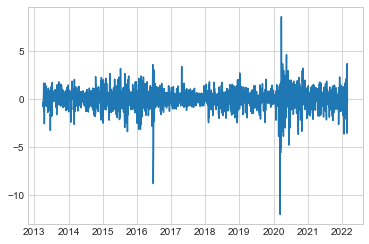

In [60]:
plt.plot(rt['date'], rt['MktRF']);

In [61]:
filt = (rt['date'] >= pd.to_datetime('2013-01-01')) & (rt['date'] <= pd.to_datetime('2022-02-28')) 
rt = rt[filt]
rt.dropna(how='all', axis='index', thresh=5, inplace=True)

In [62]:
rt.describe()

,port_low,port_mid,port_high,MktRF,SMB,HML,RMW,CMA,RF,DAX Index,OMXS30B Index,OMXC25 Index,OMX Index
count,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000,2273.00000
mean,0.07785,0.04066,0.04817,0.02948,0.00846,-0.00698,0.01433,-0.00879,0.24197,0.03381,0.03118,0.05408,0.03118
std,1.04865,1.02315,1.07608,1.01498,0.41976,0.53665,0.30293,0.29614,0.42837,1.21824,1.11251,1.05332,1.11251
min,-10.32080,-10.73624,-11.41330,-12.01000,-3.32000,-3.03000,-1.74000,-1.74000,0.00000,-12.23862,-10.57105,-8.02912,-10.57117
25%,-0.40332,-0.42903,-0.42355,-0.44000,-0.23000,-0.28000,-0.16000,-0.19000,0.00000,-0.49149,-0.53259,-0.51362,-0.53247
50%,0.12352,0.07708,0.08441,0.07000,0.01000,-0.03000,0.03000,-0.01000,0.00000,0.06986,0.05814,0.06263,0.05814
75%,0.61330,0.57564,0.56844,0.55000,0.25000,0.26000,0.19000,0.16000,0.00000,0.64083,0.63850,0.67273,0.63868
max,7.27510,6.68160,8.87625,8.54000,1.86000,4.38000,2.69000,1.31000,1.00000,10.97590,7.08908,5.07265,7.08859


In [63]:
rt.loc[:,['port_low','port_mid','port_high','MktRF']].corr()

,port_low,port_mid,port_high,MktRF
port_low,1.00000,0.90316,0.87876,0.79846
port_mid,0.90316,1.00000,0.93236,0.83896
port_high,0.87876,0.93236,1.00000,0.85602
MktRF,0.79846,0.83896,0.85602,1.00000


In [64]:
model1 = smf.ols(formula='port_low ~ MktRF', data=rt).fit() 
print(model1.summary())
#trend = model1.params[0] + model1.params[1]* rt['port_low']
#plt.scatter(rt['port_low'],rt['MktRF'])
#plt.plot(trend, rt['port_low'], 'r');

                            OLS Regression Results                            
Dep. Variable:               port_low   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     3994.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -2179.4
No. Observations:                2273   AIC:                             4363.
Df Residuals:                    2271   BIC:                             4374.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0535      0.013      4.040      0.0

In [65]:
model11 = smf.ols(formula='port_low ~ MktRF + SMB + HML', data=rt).fit() 
print(model11.summary())

                            OLS Regression Results                            
Dep. Variable:               port_low   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     1378.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -2153.5
No. Observations:                2273   AIC:                             4315.
Df Residuals:                    2269   BIC:                             4338.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0512      0.013      3.900      0.0

In [66]:
model111 = smf.ols(formula='port_low ~ MktRF + SMB + HML + RMW + CMA', data=rt).fit() 
print(model111.summary())

                            OLS Regression Results                            
Dep. Variable:               port_low   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     829.7
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -2150.5
No. Observations:                2273   AIC:                             4313.
Df Residuals:                    2267   BIC:                             4347.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0500      0.013      3.813      0.0

In [67]:
model2 = smf.ols(formula='port_mid ~ MktRF', data=rt).fit() 
print(model2.summary())
#trend = model2.params[0] + model2.params[1]* rt['port_mid']
#plt.scatter(rt['port_mid'],rt['MktRF'])
#plt.plot(trend, rt['port_mid'], 'r');

                            OLS Regression Results                            
Dep. Variable:               port_mid   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     5397.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -1893.8
No. Observations:                2273   AIC:                             3792.
Df Residuals:                    2271   BIC:                             3803.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0157      0.012      1.346      0.1

In [68]:
model22 = smf.ols(formula='port_mid ~ MktRF + SMB + HML', data=rt).fit() 
print(model22.summary())

                            OLS Regression Results                            
Dep. Variable:               port_mid   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     1943.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -1830.9
No. Observations:                2273   AIC:                             3670.
Df Residuals:                    2269   BIC:                             3693.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0192      0.011      1.690      0.0

In [69]:
model222 = smf.ols(formula='port_mid ~ MktRF + SMB + HML + RMW + CMA', data=rt).fit() 
print(model222.summary())

                            OLS Regression Results                            
Dep. Variable:               port_mid   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1167.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -1829.5
No. Observations:                2273   AIC:                             3671.
Df Residuals:                    2267   BIC:                             3705.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0189      0.011      1.657      0.0

In [70]:
model3 = smf.ols(formula='port_high ~ MktRF', data=rt).fit() 
print(model3.summary())
#trend = model3.params[0] + model3.params[1]* rt['port_high']
#plt.scatter(rt['port_high'],rt['MktRF'])
#plt.plot(trend, rt['port_high'], 'r');

                            OLS Regression Results                            
Dep. Variable:              port_high   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     6227.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -1891.7
No. Observations:                2273   AIC:                             3787.
Df Residuals:                    2271   BIC:                             3799.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0214      0.012      1.835      0.0

In [71]:
model33 = smf.ols(formula='port_high ~ MktRF + SMB + HML', data=rt).fit() 
print(model33.summary())

                            OLS Regression Results                            
Dep. Variable:              port_high   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     2410.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -1764.3
No. Observations:                2273   AIC:                             3537.
Df Residuals:                    2269   BIC:                             3559.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0286      0.011      2.589      0.0

In [72]:
model333 = smf.ols(formula='port_high ~ MktRF + SMB + HML + RMW + CMA', data=rt).fit() 
print(model333.summary())

                            OLS Regression Results                            
Dep. Variable:              port_high   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     1473.
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:10:01   Log-Likelihood:                -1747.1
No. Observations:                2273   AIC:                             3506.
Df Residuals:                    2267   BIC:                             3541.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0252      0.011      2.291      0.0